# 3. 有意性の推定

測定された散乱事象数は測定に対してどの程度一致したでしょうか？ラザフォード散乱があることを再発見するためには、なるべく大角度での散乱事象を観測することが望ましいです。一方で、予測と大幅に異なる場合はその原因を理解する必要があります。

まずは前回までの推定結果を引き継ぎましょう。
3.0.1で前回と同じ設定を引き継ぎます。続いて3.0.2を**前回のノートにコピーして**0.1から順に実行したのち、3.0.2を実行してください。1.1.5.を実行後に1.1.2-3.を再実行するのもお忘れなく。出力結果を3.0.3.にコピーして実行してください。3.0.4.を実行すると前回の推定が再現されるはずです。

In [ ]:
# @title 3.0.1. 必要設定の読み込み

#スクリプト実行に必要なパッケージ。
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from scipy.stats import poisson,norm
from scipy import integrate

#用いる関数を定義
def gaussian(x, a, m, s):#ガウシアン
    return a*np.exp(-0.5*(x-m)**2/s**2)
def lin(x,a,b):
    return a*x+b
def dlin(x,a,b,dx,da,db):#直線フィッティングの誤差導出用関数
    dy=(x*da)**2
    dy+=(dx*a)**2
    dy+=db**2
    dy=np.sqrt(dy)
    #print("{:10.4f}, {:10.4f}, {:10.4f}".format((x*da),dx*a,db))
    return dy
def pathToTime(path):
    time_format='"%Y-%m-%d" "%H:%M:%S"'
    temp = np.genfromtxt(path, skip_header=1025,skip_footer=1,dtype=str)
    start_text=temp[0]+' '+temp[1]
    start_time=datetime.datetime.strptime(start_text, time_format)
    end_text=temp[2]+' '+temp[3]
    end_time=datetime.datetime.strptime(end_text, time_format)
    Time=(end_time-start_time).seconds
    return Time
def significance(n, b, sigma): #有意性を返す式
    return (n-b)/np.sqrt(b+sigma**2)
def prob(Z):#有意性を「観測した事象より大きく予想から外れる確率」に解釈しなおす式
    return 1-(norm.cdf(Z)-norm.cdf(-Z))
def rebin(x,y,ndiv=3):
    bins = len(x)-1
    # ndiv
    print(len(x),x[-1],ndiv,bins%ndiv)
    if bins%ndiv != 0:
      return rebin(x[:-1],y[:-1],ndiv)
    bins_new = int(bins/ndiv)
    print(bins_new)
    dx=x[1]-x[0]
    x_new = np.linspace(x[0],x[-1], bins_new+1)
    y_new = np.array([np.sum(y[i*ndiv:(i+1)*ndiv]) for i in range(bins_new+1)])
    print(len(x_new),x_new[-1])
    return x_new, y_new

#実験データなど、Googleドライブにあるファイルにアクセスしたい場合に実行する。自分のアカウントで要認証。
from google.colab import drive
drive.mount('/content/drive')

#ファイルを格納するディレクトリを指定、"b3exp_alpha"という名前のディレクトリをマイドライブ直下に作ることを推奨
basePath='/content/drive/MyDrive/b3exp_alpha/'

In [ ]:
# @title 3.0.2. 各種設定の引継ぎ（day1にコピーして使う！）
print(f"a_ev={a_ev:5.2e}")
print(f"da_ev={da_ev:5.2e}")
print(f"b_ev={b_ev:5.2e}")
print(f"db_ev={db_ev:5.2e}")
print(f"drt={drt:5.2e}")
print(f"drs={drs:5.2e}")
print(f"Lrs={Lrs:5.2e}")
print(f"Lrt={Lrt:5.2e}")
print(f"Lts={Lts:5.2e}")
print(f"B0={B0:5.2e}")
print(f"dB0={dB0:5.2e}")
print(f"RAl={RAl:5.2e}")
print(f"dRAl={dRAl:5.2e}")
print(f"RAu={RAu:5.2e}")
print(f"dRAu={dRAu:5.2e}")
print(f"NAl={NAl:5.2e}")
print(f"dNAl={dNAl:5.2e}")
print(f"NAu={NAu:5.2e}")
print(f"dNAu={dNAu:5.2e}")
print(f"AAl={AAl:5.2e}")
print(f"AAu={AAu:5.2e}")
print(f"theta={theta:5.2e} #必要に応じて編集する")
print(f"t={t:5.2e} #必要に応じて編集する")
print(f"basePath=\"{basePath}\"")

In [ ]:
# @title 3.0.3. 必要設定のコピー場所(day1からコピーしてくる)

#以下はダミーデータ。上書きすること。
a_ev=6.19e-03
da_ev=5.58e-05
b_ev=1.29e-01
db_ev=3.18e-02
drt=3.00e+00
drs=3.00e+00
Lrs=1.30e+02
Lrt=6.00e+01
Lts=7.00e+01
B0=2.69e+06
dB0=1.79e+04
RAl=3.92e+00
dRAl=4.82e-01
RAu=2.31e+00
dRAu=1.51e-01
NAl=8.82e+19
dNAl=2.90e+18
NAu=3.36e+19
dNAu=8.88e+17
AAl=4.33e+00
AAu=1.60e+02
theta=1.00e+01 #必要に応じて編集する
t=7.20e+03 #必要に応じて編集する
basePath="/content/drive/MyDrive/b3exp_alpha/"

In [ ]:
# @title　3.0.4. 必要な計算式の再定義
S1=np.pi*drt**2
S2=np.pi*drs**2
dOmega_RtoS=S2/Lrs**2
dOmega_RtoT=S1/Lrt**2
dOmega_TtoS=S2/Lts**2
B=B0*dOmega_RtoT/4/np.pi
dB=dB0*dOmega_RtoT/4/np.pi
dsigmadOmegaAl=AAl*(np.sin(np.radians(theta)/2))**-4
dsigmadOmegaAu=AAu*(np.sin(np.radians(theta)/2))**-4

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
x=np.arange(5,90)#プロットするx軸のbinを設定
fAl=AAl*(np.sin(np.radians(x)/2))**-4
fAu=AAu*(np.sin(np.radians(x)/2))**-4
ax.plot(x, fAl, 'b-',label='Al theory')
ax.plot(x, fAu, 'r-',label='Au theory')
plt.scatter(theta,dsigmadOmegaAl,marker="o",color="b",label='Al expected')#理論値Al
plt.scatter(theta,dsigmadOmegaAu,marker="o",color="r",label='Au expected')#理論値Al
plt.yscale('log')  # ログスケール
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel(r'$d\sigma/d\Omega$ (fm$^2$)')
plt.legend(loc='upper right')

N_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS
dN_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAl)**2)+(dNAl/NAl)**2)
print("推定測定回数(Al)={:10.1e}+/-{:10.1e}".format(N_expectedAl,dN_expectedAl))
N_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS
dN_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAu)**2)+(dNAu/NAu)**2)
print("推定測定回数(Au)={:10.1e}+/-{:10.1e}".format(N_expectedAu,dN_expectedAu))

実際の測定はどのような結果になったでしょうか？3.0.5に測定ファイルを設定し、確認してください。

In [ ]:
# @title 3.0.4. 観測結果読み込み
#散乱測定ファイル、ファイル名と測定角度を任意の回数入れる
Al_file_list=[]
Al_file_list.append(['300sec20degAl.csv',20])
Al_file_list.append(['60sec10degAl.csv',10])
Au_file_list=[]
Au_file_list.append(['Au50deg68h.csv',50])


theta_Al=[]
dsdW_Al=[]
Nmes_Al=[]
Nexp_Al=[]
dNexp_Al=[]
fig_list=[]
x=np.arange(0,1024)#x軸
for file_i in Al_file_list :
  Al_file=np.genfromtxt(basePath+file_i[0], skip_footer=6)
  theta_Al.append(file_i[1])
  Nsig=np.sum(Al_file)
  tmes=pathToTime(basePath+file_i[0])
  dsdW_Al.append(Nsig/(B*tmes*NAl*1e-26*dOmega_TtoS))
  Nmes_Al.append(Nsig)
  Nexp_Al.append(B*tmes*NAl*1e-26*AAl*(np.sin(np.radians(file_i[1])/2))**-4*dOmega_TtoS)
  dNexp_Al.append(B*tmes*NAl*1e-26*AAl*(np.sin(np.radians(file_i[1])/2))**-4*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAl)**2)+(dNAl/NAl)**2))
  print("測定数　{:.2f} 測定時間{:.2f}".format(Nsig,tmes))

  fig_i = plt.figure(figsize=(6, 6))
  fig_list=np.append(fig_list,fig_i)
  ax = fig_list[-1].add_subplot(111)
  _ = ax.hist(x, bins=1024, weights=Al_file, range=(0, 1024), alpha=0.5, label='Al data {:.0f}$^\circ$ taking in {:.0f} sec\ntotal count {:.0f}'.format(file_i[1],tmes,Nsig))
  plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
  plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
  plt.legend(loc='upper right')


theta_Au=[]
Nmes_Au=[]
Nexp_Au=[]
dNexp_Au=[]
dsdW_Au=[]
for file_i in Au_file_list :
  Au_file=np.genfromtxt(basePath+file_i[0], skip_footer=6)
  theta_Au.append(file_i[1])
  Nsig=np.sum(Au_file)
  tmes=pathToTime(basePath+file_i[0])
  dsdW_Au.append(Nsig/(B*tmes*NAu*1e-26*dOmega_TtoS))
  Nmes_Au.append(Nsig)
  Nexp_Au.append(B*tmes*NAu*1e-26*AAu*(np.sin(np.radians(file_i[1])/2))**-4*dOmega_TtoS)
  dNexp_Au.append(B*tmes*NAu*1e-26*AAu*(np.sin(np.radians(file_i[1])/2))**-4*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAu)**2)+(dNAu/NAu)**2))
  print("測定数　{:.2f} 測定時間{:.2f}".format(Nsig,tmes))

  fig_i = plt.figure(figsize=(6, 6))
  fig_list=np.append(fig_list,fig_i)
  ax = fig_list[-1].add_subplot(111)
  _ = ax.hist(x, bins=1024, weights=Au_file, range=(0, 1024), alpha=0.5, label='Au data {:.0f}$^\circ$ taking in {:.0f} sec\ntotal count {:.0f}'.format(file_i[1],tmes,Nsig))
  plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
  plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
  plt.legend(loc='upper right')

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
theta_x=np.arange(1,90)#プロットするx軸のbinを再設定
fAl=AAl*(np.sin(np.radians(theta_x)/2))**-4
fAu=AAu*(np.sin(np.radians(theta_x)/2))**-4
ax.plot(theta_x, fAl, 'b-',label='Al theory')
ax.plot(theta_x, fAu, 'r-',label='Au theory')
plt.yscale('log')  # ログスケール
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel(r'$d\sigma/d\Omega$ (fm$^2$)')
plt.errorbar(theta_Al,dsdW_Al,fmt="o",color="b",label='Al data')#測定値Al
plt.errorbar(theta_Au,dsdW_Au,fmt="o",color="r",label='Au data')#測定値Au
plt.legend(loc='upper right')

測定事象数は推定事象数に対してどの程度一致していますか？定量的に評価してみましょう。推定信号事象数がs±dsのとき、測定事象数がnで統計誤差のみを考えればよいなら、そのずれ度合いは
$$
\frac{n-s}{\sqrt{n+ds^2}}
$$
で得られます。誤差が適切に評価されていれば、この値は標準偏差1の正規分布に従います。

In [ ]:
# @title 3.0.5. 推定値比較
for s,ds,n in zip(Nexp_Al,dNexp_Al,Nmes_Al):
  sig_dif=(n-s)/np.sqrt(n+ds**2)
  print("Al expected {:.2e}+/-{:.2e}, observed {:.2e} -> {:.2e}σ ".format(s,ds,n,sig_dif))

for s,ds,n in zip(Nexp_Au,dNexp_Au,Nmes_Au):
  sig_dif=(n-s)/np.sqrt(n+ds**2)
  print("Au expected {:.2e}+/-{:.2e}, observed {:.2e} -> {:.2e}σ ".format(s,ds,n,sig_dif))

予想が完全に正しければ、正負に同程度ふらつくはずですが、そのようにならないことが多いでしょう。ここまで議論されていない要素として、背景事象と系統誤差があります。それぞれについて以下で議論します。

# 3.1. 背景事象推定

背景事象は実験において重要な要素です。背景事象がb±dbと推定できれば、ずれ度合いは

$$
\frac{n-s-b}{\sqrt{n+ds^2+db^2}}
$$

となります。ずれを背景事象に押し付けることが可能なようにも見えます[<sup>1</sup>](#id_01)が、背景事象が多すぎると、信号事象があるかないかの議論が困難になります。定量的に信号事象があることを示すには、観測された事象数nが「背景事象数bと誤差σの仮定のみで観測される確率」を計算します。そして**背景事象だけで実際に観測された事象数が説明できてしまう確率が十分小さい**ことを示すことで、信号が有意であることを示します。具体的には

$$
Z=\frac{s}{\sqrt{b+ds^2+db^2}}
$$

を有意度[<sup>2</sup>](#id_02)と呼びます。これが大きければ、信号を優位に観測したと言えます。

式からもわかるように、背景事象をいかに減らせるか、背景事象を信号事象からどれだけ正確に取り除けるか、そのうえで信号事象をいかに稼げるかが課題となります。

今回の実験では、背景事象としては次のようなものが考えられます

1.   線源とは無関係な自然放射線の入射
2.   薄膜を通過せずに直接センサーへ入射する粒子
3.   薄膜以外の位置で散乱されてセンサーに入射する粒子


1.に関しては、先行実験で線源のない状態でt=4515秒の測定を行い$N_{obs}$=1イベントが観測されました。統計数が少ないためポアソン分布
$$
P(N|\lambda, t)=\frac{e^{-\lambda t}(\lambda t)^N}{N!}
$$
を仮定します。ここでは１度しか計測していないので、λに関して保守的な見積もりをします。具体的には、観測数が$N_{obs}$かそれ以下である確率が5%となるような最大のλを採用します。

$$
\Sigma_{N=0}^{N_{obs}}P(N|\lambda, t)=0.05
$$

3.1.1.を実行して、$\lambda$を求めましょう。より長時間の測定を行えば、保守的な推測でも$\lambda$の値は小さくなります。

<span id="id_01">[1]一般的な実験では、背景事象も綿密な見積もりの上に、推定値を計算して比較を行います。</span>

<span id="id_02">[2]確率分布がbを中心とした幅$b+ds^2+db^2$のガウシアンと仮定すると得られる。背景事象が十分にない場合はガウシアンでなくポアソン分布を仮定する必要があり、より複雑な式で計算する必要がある。</span>

In [ ]:
# @title 3.1.1. 自然放射線量の推定
def N_to_lambda(N,p):
    bnds=((N,N),(0,None))
    func=lambda x: (poisson.cdf(x[0],x[1])-p)**2
    res=minimize(func,(N,N*2),bounds=bnds)
    for i in range(0,N+1):
      print("{:2d} {:.2e}".format(i,100*poisson.pmf(i,res.x[1])))
    return res.x[1]

Nobs=1
t=4515
lamb=N_to_lambda(Nobs,0.05)
tmes=300#測定した時間を入れる
print("推定されたλ*t={:.2e}->λ={:.2e}".format(lamb,lamb/t))
print("推定された背景事象数={:.2e} for {:.2e} sec mesure".format(lamb*tmes/t,tmes))


2.及び3.の背景事象に関しては、様々なアイディアで推定・削減することが可能です。
議論しながら大まかに見積もり、b,dbの値を見積もってみてください。見積もりを出したら、3.1.2.で予想とのずれと有意度の議論を行いましょう。

In [ ]:
# @title 3.1.2. 誤差を考慮した予想とのずれ
bAl=[10,10]#Alの測定における背景事象推定数を測定した回数入れる
dbAl=[10,10]#Alの測定における背景事象推定数誤差を測定した回数入れる
bAu=[10]#Auの測定における背景事象推定数を測定した回数入れる
dbAu=[10]#Auの測定における背景事象推定数誤差を測定した回数入れる

for s,ds,n,b,db in zip(Nexp_Al,dNexp_Al,Nmes_Al,bAl,dbAl):
  sig_dif=(n-s-b)/np.sqrt(n+ds**2+db**2)
  significance=s/np.sqrt(b+ds**2+db**2)
  print("Al expected {:.2e}+/-{:.2e}, background {:.2e}+/-{:.2e}, observed {:.2e} -> diff {:.2e}σ, significance(exp) {:.2e}σ ".format(s,ds,b,db,n,sig_dif,significance))

for s,ds,n,b,db in zip(Nexp_Au,dNexp_Au,Nmes_Au,bAu,dbAu):
  sig_dif=(n-s-b)/np.sqrt(n+ds**2+db**2)
  significance=s/np.sqrt(b+ds**2+db**2)
  print("Au expected {:.2e}+/-{:.2e}, background {:.2e}+/-{:.2e}, observed {:.2e} -> diff {:.2e}σ, significance(exp) {:.2e}σ ".format(s,ds,b,db,n,sig_dif,significance))

# 3.2. 誤差推定

これまでは各種測定事象数に依存する統計誤差とその伝搬のみを誤差として取り扱ってきました。しかし、実際には測定装置や測定手法に依存する誤差も考慮する必要があります。背景事象の推定においては、推定手法に依存した誤差がないか検討しましょう。

信号事象においては、理論的な推定数に対し実際に観測された事象数に大きな乖離が見られたのではないでしょうか。これに関しても、誤差を議論することで理解することができます。3.2.1.をヒントとして用いて、誤差の原因について議論しましょう。

In [ ]:
# @title 3.2.1. 角度議論用ツール
L2=11.7#mm ターゲット手前のウィンドウからターゲットまでの距離

flag=1#revert flag
alpha=-1*flag#cos(agnle) on target
beta=1*flag#cos(angle) on sensor
gamma=1*flag#cos(angle) on radiation source
dsi=5#mm, window size of radiation source

theta_orig=13
theta_orig=np.radians(theta_orig)

vL12=np.array([0,0,Lrt+L2])
vdL12=np.array([alpha*np.cos(np.pi/6),0,alpha*np.sin(np.pi/6)])
vdL12*=drt*(Lrt+L2)/Lrt
vdLi=np.array([dsi*gamma,0,0])
vLI=vL12+vdL12-vdLi

vL3=np.array([-Lts*np.sin(theta_orig),0,Lts*np.cos(theta_orig)])
vdL3=np.array([drs*beta*np.sin(theta_orig),0,drs*beta*np.cos(theta_orig)])
vLO=vL3+vdL3-vdL12
print("流入ベクトル角度{:.3f}° 散乱ベクトル角度{:.3f}° 散乱しない粒子の流入が可能か{:b}".format(np.degrees(np.arctan(vLI[0]/vLI[2])),np.degrees(np.arctan(vLO[0]/vLO[2])),np.degrees(np.arctan(vLI[0]/vLI[2]))<np.degrees(np.arctan(vLO[0]/vLO[2]))))

thetap=np.arccos(np.dot(vLI,vLO)/np.sqrt(np.dot(vLI,vLI)*np.dot(vLO,vLO)))
print("最小流入可能角度{:.3f}°".format(np.degrees(thetap)))

dsigmadOmegaAl=AAl*(np.sin(np.radians(thetap)/2))**-4
dsigmadOmegaAu=AAu*(np.sin(np.radians(thetap)/2))**-4
N_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS
dN_expectedAl=B*t*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAl)**2)+(dNAl/NAl)**2)
print("最小流入可能角度での推定測定回数(Al)={:10.1e}+/-{:10.1e}".format(N_expectedAl,dN_expectedAl))
N_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS
dN_expectedAu=B*t*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAu)**2)+(dNAu/NAu)**2)
print("最小流入可能角度での推定測定回数(Au)={:10.1e}+/-{:10.1e}".format(N_expectedAu,dN_expectedAu))

# 3.3. 結果確認

結果をまとめましょう。観測数が分かったらnew_rowを書き換えて実行してください。**このセルのみ実行後修正が必要な場合は管理者の操作が必要です。**慣れるまでは実行前に一声かけてください。

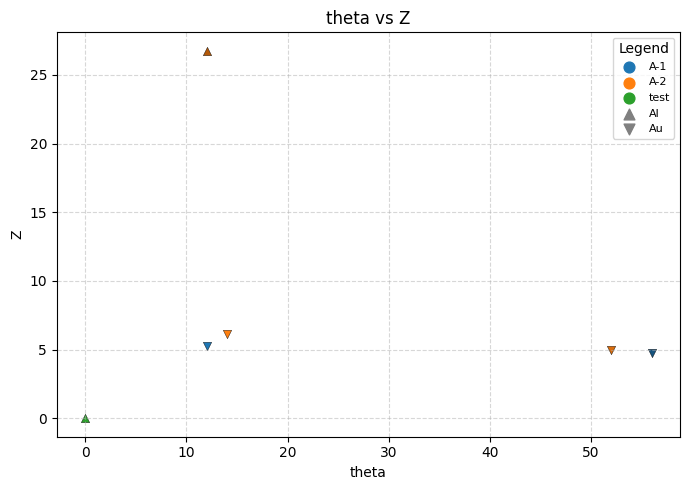

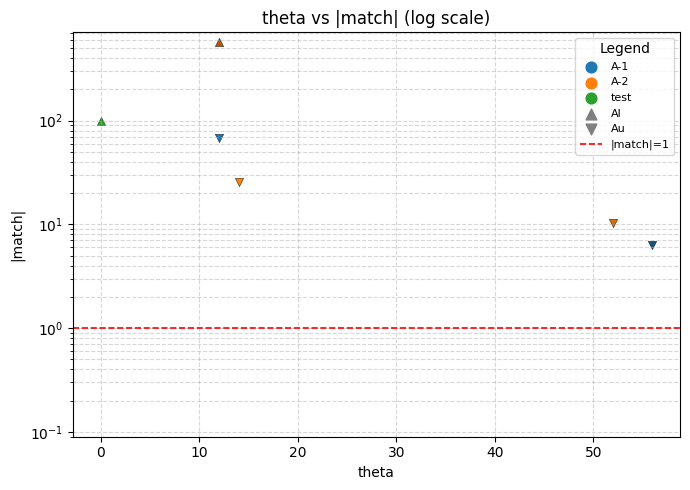

In [23]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb

# --- データ取得 ---
url = "https://script.google.com/macros/s/AKfycbwbeOC2A1o1zm0L1dGLMoV_7y905ST80tijvzilIJ32drZms_iwnObMsFRovgyJyQsG/exec"
new_row = {
    "班": "test",
    "trial": 0,
    "type": "Al",  # ← Al または Au
    "time": "0",
    "theta": 0,
    "Nexp": 0,
    "dNexp": 1,
    "syst": 0,
    "b": 0,
    "db": 0,
    "Nobs": 98
}
res = requests.post(url, json=new_row)
data = res.json()
df = pd.DataFrame(data)

# --- 設定 ---
班_list = sorted(df["班"].unique())
type_list = sorted(df["type"].unique())
班_colors = plt.cm.tab10(range(len(班_list)))
type_markers = {"Al": "^", "Au": "v"}

def gradient_color(base_color, n, idx):
    """代表色から白に向かってグラデーション"""
    target = np.array(base_color[:3])*0.7
    base = np.array(base_color[:3])
    ratio = idx/(n-1) if n>1 else 0
    return base*(1-ratio) + target*ratio

def plot_xy(y_col, title, log_scale=False, abs_value=False):
    plt.figure(figsize=(7,5))
    all_y = []
    for i, b in enumerate(班_list):
        df_b = df[df["班"] == b]
        base_color = to_rgb(班_colors[i])
        trials = sorted(df_b["trial"].unique())
        for j, t in enumerate(trials):
            df_bt = df_b[df_b["trial"] == t]
            color = gradient_color(base_color, len(trials), j)
            for ty in type_list:
                df_btt = df_bt[df_bt["type"] == ty].copy()
                if abs_value:
                    df_btt[y_col] = np.abs(df_btt[y_col])
                all_y.extend(df_btt[y_col].dropna())
                plt.scatter(df_btt["theta"], df_btt[y_col],
                            color=color, marker=type_markers.get(ty, "o"),
                            edgecolors='black', linewidths=0.3)

    # === 凡例 ===
    for i, b in enumerate(班_list):
        plt.scatter([], [], color=班_colors[i], label=f"{b}", s=60)
    for ty, m in type_markers.items():
        plt.scatter([], [], color="gray", marker=m, label=f"{ty}", s=60)

    plt.xlabel("theta")
    plt.ylabel(y_col if not abs_value else f"|{y_col}|")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5, which='both')

    # === logスケール & 下限設定 ===
    if log_scale:
        plt.yscale("log")
        if all_y:
            ymin = min(np.nanmin(all_y), 0.1)
            plt.ylim(bottom=ymin * 0.9)  # 少し余裕を持たせる
        # y=1 に赤線
        plt.axhline(1, color='red', linestyle='--', linewidth=1.2, label="|match|=1")

    plt.legend(title="Legend", fontsize=8, frameon=True, loc='best')
    plt.tight_layout()
    plt.show()

# === プロット ===
plot_xy("Z", "theta vs Z")
plot_xy("match", "theta vs |match| (log scale)", log_scale=True, abs_value=True)
